# Parameter Estimation

In [1]:
# Packages

import sys
sys.path.append('../datasets') 
import dataset_long as dsl

# Model
import numpy as np
import tellurium as te
# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
# Dataframe
import pandas as pd

#Estimation
import paramfitt_singlePatient as pf 
from scipy.optimize import minimize 
from collections import OrderedDict
from scipy.stats import qmc
from scipy.optimize import basinhopping
from scipy.optimize import differential_evolution
import json
#Analyse Estimation
from scipy.stats import chi2
from scipy.stats import norm

### import charite-Data and  Model

In [2]:
#import Data of charite
df = pd.read_excel('.././datasets/haemolysismodel_conRetis.xlsx')
df = dsl.long_format(df)
#df_long[['time','measurement','patientnumber']].head(10)
#df.head(21)


### Pick out Patient

<Axes: xlabel='time', ylabel='[E]'>

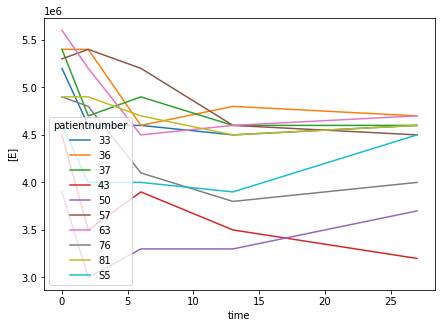

In [ ]:
# PTH patient 

#soll keine Nan in Hb Werten haben
df_sinHbNan = df.copy()
df_sinHbNan = df_sinHbNan.groupby(['patientnumber']).filter(lambda group: ~(group['Hb'].isnull().any()))
#df_sinHbNan = df_sinHbNan.groupby(['patientnumber']).filter(lambda group: ~((group['[oiE]'].isnull()& (group['time'] != 0)).any()))
df_PTH = df_sinHbNan.groupby('patientnumber').filter(lambda group: (group['PTH'] == 1).any())

#außerdem viele Werte in LDH, R, oiE, ..

plt.figure( figsize=(7,5))
sns.lineplot(x='time', y='[E]', hue='patientnumber', data =df_PTH)#, legend='')

<Axes: xlabel='time', ylabel='Hb'>

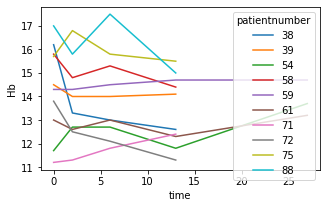

In [ ]:
#non PTH patient

#letzter Wert nicht wichtig, alle patienten raus die Nan in Hb werten haben (außer letzter)
df_sinHbNan = df.copy()


df_sinHbNan = df_sinHbNan.groupby(['patientnumber']).filter(lambda group: ~((group['Hb'].isnull() & (group['time'] != 27)).any()))
df_sinHbNan = df_sinHbNan.groupby(['patientnumber']).filter(lambda group: ~((group['RPI'].isnull()& (group['time'] != 27)).any()))
df_sinHbNan = df_sinHbNan.groupby(['patientnumber']).filter(lambda group: ~((group['LDH'].isnull()& (group['time'] != 27)).any()))
df_sinHbNan = df_sinHbNan.groupby(['patientnumber']).filter(lambda group: ~((group['[oiE]'].isnull() & (group['time'] != 0) & (group['time'] != 27)).any()))

df_noPTH = df_sinHbNan.groupby('patientnumber').filter(lambda group: (group['PTH'] == 0).any())


plt.figure( figsize=(5,3))
sns.lineplot(x='time', y='Hb', hue='patientnumber', data =df_noPTH)#, legend='')


<Axes: xlabel='time', ylabel='Hkt'>

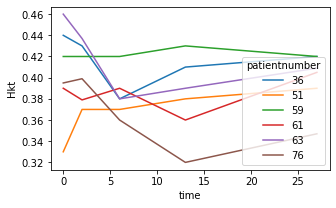

In [7]:
patient_numbers_to_keep = ['51', '61','59', '36', '63', '76']
df_selected = df[df['patientnumber'].isin(patient_numbers_to_keep)]



plt.figure( figsize=(5,3))
sns.lineplot(x='time', y='Hkt', hue='patientnumber', data =df_selected)#, legend='')

#df_selected

#PADH: 36, nonPADH:59

### Preprocessing Charite-Data for Estimation

In [ ]:
lab_values = pf.get_lab_values()

df_pat_noPADH = df[df['patientnumber'] == '59']
df_pat_noPADH = df_pat_noPADH.set_index('time')[lab_values]

df_pat_noPADH

,Hkt,[E],Hb,LDH,[R],[oiE],[iE]
time,,,,,,,
0,0.42,4500000.0,14.3,404.0,71300.0,NaN,4500.0
2,0.42,4600000.0,14.3,297.0,46200.0,3220.000000,NaN
6,0.42,4700000.0,14.5,290.0,79600.0,3181.049065,NaN
13,0.43,4800000.0,14.7,269.0,88700.0,8888.888880,NaN
27,0.42,4800000.0,14.7,264.0,98500.0,1619.537280,NaN


In [ ]:
lab_values = pf.get_lab_values()

df_pat_PADH = df[df['patientnumber'] == '36']
df_pat_PADH = df_pat_PADH.set_index('time')[lab_values]

df_pat_PADH

,Hkt,[E],Hb,LDH,[R],[oiE],[iE]
time,,,,,,,
0,0.44,5400000.0,15.9,NaN,NaN,NaN,10800.0
2,0.43,5400000.0,15.9,721.0,36100.0,37406.749536,NaN
6,0.38,4600000.0,13.6,372.0,95600.0,134464.875068,NaN
13,0.41,4800000.0,14.2,424.0,105200.0,NaN,NaN
27,0.42,4700000.0,14.3,249.0,99500.0,5687.000000,NaN


### Plot Patients

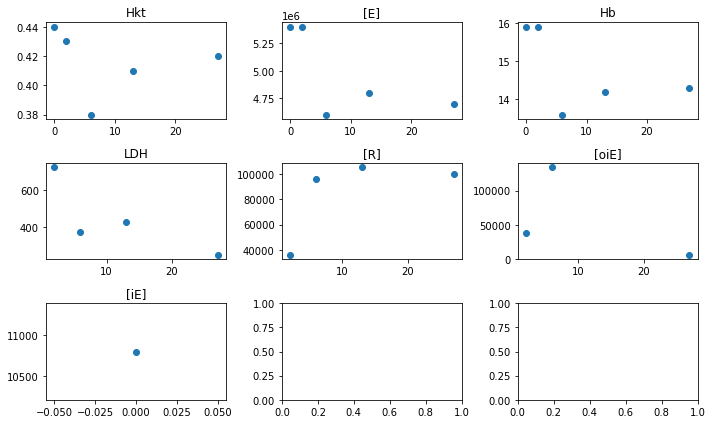

In [ ]:
lab_values = pf.get_lab_values()
data_df = df_pat_PADH

fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(10,6))
for i, lab_value in enumerate(data_df.columns):
    col = i%3
    row = i//3
    ax[row, col].plot(data_df.index, data_df[lab_value], 'o')
    ax[row, col].set_title(lab_value)
plt.tight_layout()
plt.show()


### Plotting Simulation and Experimental Data

In [ ]:
lab_values = pf.get_lab_values()
df_input_PTH = df_pat_PADH

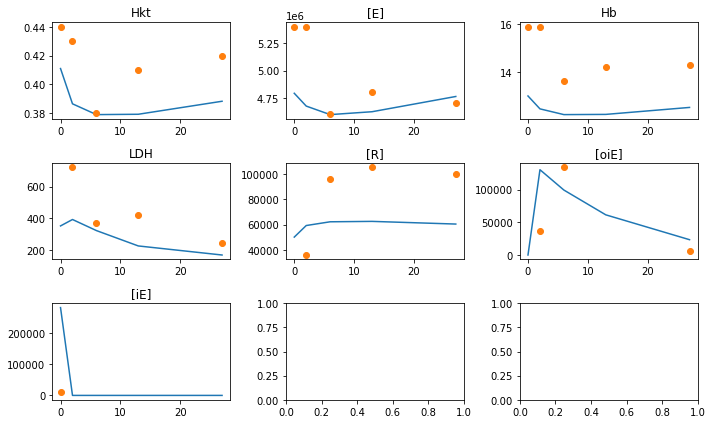

In [ ]:
def plot_simulation_and_experiment(data_df, sim_df, figsize=(10, 6)):
    n_subplots = len(sim_df.columns)
    n_cols = 3
    n_rows = int(np.ceil(n_subplots/n_cols))

    fig, ax = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=figsize)

    for i, lab_value in enumerate(sim_df.columns):
        col = i%n_cols
        row = i//n_cols
        ax[row, col].plot(sim_df.index, sim_df[lab_value])
        ax[row, col].plot(data_df.index, data_df[lab_value],'o')
        #ax[row, col].errorbar(data_df.index, data_df[f"{lab_value}_mean"], yerr=data_df[f"{lab_value}_std"], fmt='o')
        ax[row, col].set_title(lab_value)
    plt.tight_layout()
    plt.show()

patient = '36' # nonPADH
lab_values = pf.get_lab_values()
df_simulated_data = pf.simulate_model('../model/OIE_model.ant' , lab_values)
df_experiment= pf.preprocess_experimental_df(df,patient, lab_values)

plot_simulation_and_experiment(df_experiment, df_simulated_data, figsize=(10, 6))

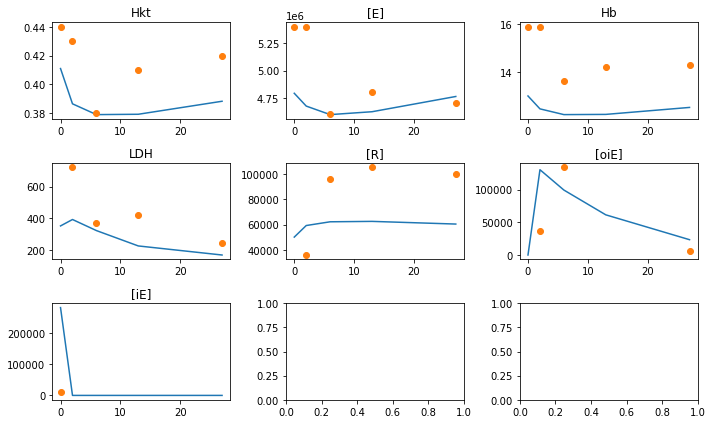

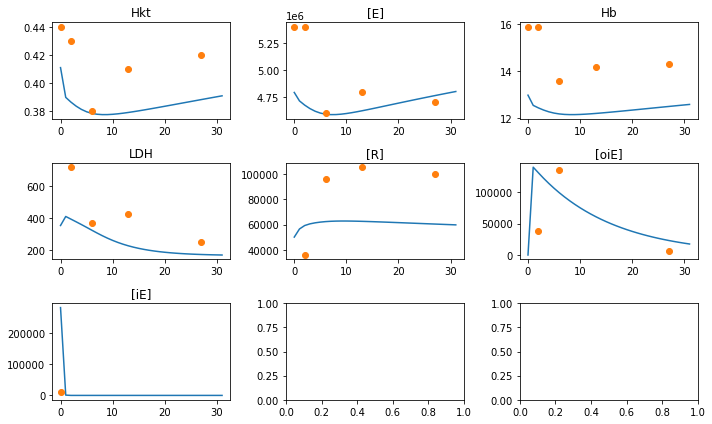

In [ ]:
#Plotting

#Model Daten
#ant_model = '.././model/OIE_model.ant'
df_simulated_data = pf.simulate_model('.././model/OIE_model.ant' , pf.get_lab_values())
#sim plot Daten
df_sim_plot = pf.simulated_data_for_plot('.././model/OIE_model.ant', pf.get_lab_values())

#experimentelle Daten
df = dsl.long_format( pd.read_excel('.././datasets/haemolysismodel_conRetis.xlsx'))
patient = '36'
df_experimental_data = pf.preprocess_experimental_df(df, patient, pf.get_lab_values())

#Plotten
pf.plot_simulation_and_experiment(df_experimental_data, df_simulated_data)
pf.plot_simulation_and_experiment(df_experimental_data, df_sim_plot)


### Optimization 

In [ ]:

#model
ant_model = '.././model/OIE_model.ant'

#experimentelle Daten
patient = '36'
data_df = pd.read_excel('.././datasets/haemolysismodel_conRetis.xlsx')   
df = dsl.long_format(data_df)
df_experimental_data = pf.preprocess_experimental_df(df, patient, pf.get_lab_values())

params_guess = pf.get_params_guess()
params_bounds = pf.get_params_bounds() 






#"""

#define an initial guess for the parameter values (add more from model)
params_guess =OrderedDict({
    'M': 40e3,
    'k_R_death': 0,
    'k_E_infect': 1e-6 ,

    'k_iE_rupture':1,

    'param1_Pdeath': 0.00071535,
    'param2_Pdeath': 0.48924947,

    'I0_iE':    0, 
    'I0_death_oiE': 0,    
    'Imax_iE': 10,    
    'hill' :2.0,      
    'ID50': 20,

    't_oiE_death': 10,   
    't_halb_LDH_decay': 10, #4,

    'k_BH': 5e-4,
    'J_oiEdeath_0': 7500,

    'BH_max': 1,
    't_ART_add': 7,
    #'k_iE_kill_proportion': 0.5,
    })

#define bounds of parameters values
params_bounds =OrderedDict({
    'M': (1e2,1e5),
    'k_R_death': (0, 1e-4),            #k_R_death < k_R_aging=1.38, drei einheiten kleiner setzen
    'k_E_infect': (1e-8 , 1e-4),
    'k_iE_rupture':(1e-1, 10),

    'param1_Pdeath': (0, 1e-2),
    'param2_Pdeath': (0, 10),

    'I0_iE':    (0, 1e-3),            #vlt auf 0 setzen ausprobieren, Inhibition ohne ART, zw. 0 und viel kleiner als Imax_iE 
    'I0_death_oiE': (0, 1e-3), 
    'Imax_iE': (1, 1000),             # maximale abtötrate von iE durch ART 
    'hill' :(1, 4),                 #Anstieg, sehr sensibey= 
    'ID50': (1e-1, 1000),               #ART dosis bei der 50% der iE getötet werden       

    't_oiE_death': (5,15),           #Zeit nach der oiE sterben, nach ca. 7- 14
    't_halb_LDH_decay': (2,14),      # Halbwertzeit von LDH, 3-5 Tage+ Puffer

    'k_BH': (5e-5, 5e-3),    # Anstieg Kurve 
    'J_oiEdeath_0': (5000, 10000),    # in Modell max. 15.000

    'BH_max': (0,5),
    't_ART_add': (3,20),
    #'k_iE_kill_proportion': (0,1),

    })
#"""
#def bounds in log-space überführen (kein 0 )---- check

#def latin_hypercube_sampling   --- check


# def get_initalguess(param_space):
#     """
#     input: ordDict: {'param2_EPOprod': (0,300, True),... }
#     return: 
#         param_names: list 
#         bounds: liste
#         intialguess: [[intial_guess1],[initial_guess2]]
#     """
#     # log bounds nutzen ->  create inital guess with sampling with lhc

#print(list(params_guess.values()))


#run the optimization

"""
result = minimize(pf.objectiv_function, x0=list(params_guess.values()), args=(df_experimental_data, ant_model, params_guess.keys()), bounds=list(params_bounds.values()) )
print('Optimal parameter values: ', result.x)
print('Residual error: ', result.fun)



try:
    result = minimize(pf.objectiv_function, x0=list(params_guess.values()), args=(df_experimental_data, ant_model, params_guess.keys()), bounds=list(params_bounds.values()) )
    print('Optimal parameter values: ', result.x)
    print('Residual error: ', result.fun)
except RuntimeError: 
    pass
"""

#print('Optimal parameter values: ', result.x)
#print('Residual error: ', result.fun)




"\nresult = minimize(pf.objectiv_function, x0=list(params_guess.values()), args=(df_experimental_data, ant_model, params_guess.keys()), bounds=list(params_bounds.values()) )\nprint('Optimal parameter values: ', result.x)\nprint('Residual error: ', result.fun)\n\n\n\ntry:\n    result = minimize(pf.objectiv_function, x0=list(params_guess.values()), args=(df_experimental_data, ant_model, params_guess.keys()), bounds=list(params_bounds.values()) )\n    print('Optimal parameter values: ', result.x)\n    print('Residual error: ', result.fun)\nexcept RuntimeError: \n    pass\n"

#### LHS Sample 



In [8]:
best_score = 800


params_guess = pf.get_params_guess()
params_bounds = pf.get_params_bounds() 

log_bounds= pf.convert_bounds_to_logscale(params_bounds)
#log_bounds= pf.convert_bounds_to_logscale(params_bounds)
num_samples = 100
best_samples = []

patient = '36'
data_df = pd.read_excel('.././datasets/haemolysismodel_conRetis.xlsx')   
df = dsl.long_format(data_df)
df_experimental_data = pf.preprocess_experimental_df(df, patient, pf.get_lab_values())
lab_values = pf.get_lab_values()

ant_model = '.././model/OIE_model.ant'

samples = pf.generate_LHS_sampling(log_bounds, num_samples) 
for sample in samples:
    score = pf.objectiv_function (sample, df_experimental_data, ant_model, params_guess.keys())

    if score < best_score:
        #best_score = score
        best_samples.append(sample)
        print (score, sample )

"""
[ 3.54803255 -1.81358236 -4.27216423  0.42225418 -3.30865717 -1.07910663
 -4.32307908 -5.89603513  2.73561175  0.10165592  2.76712245  0.88770583
  1.13468692 -2.87407169  3.96550888 -1.62264426  0.72811064] 

  5.348927531586301 [ 3.73420278 -3.30581388 -4.72956942 -0.78379187 -4.03014044 -0.26069986
 -5.07069374 -4.20734786  2.30523748  0.42574018  0.76348369  0.87956953
  1.01256503 -3.33625806  3.92956216  0.28011711  0.73020282]
641.9156754602582
  """

327.39941684637216 [-0.33470377  3.24348164 -6.10285754  0.48418756  2.8413253  -2.43996706
 -0.77085334 -3.83624738 -5.3189053   1.60816384  0.10877861  0.45985752
  1.13614217 -3.43629926  3.75192004 -0.93041999  0.51824583]
598.5033882090977 [-0.30334542  3.40822415 -7.94169831  0.86636225  2.67419268 -3.83846603
 -0.60342347 -5.34686401 -5.68437837  1.98686614  0.51766886  2.09007778
  0.71431722 -3.80984545  3.94968348 -0.79073465  0.56506392]
297.30526983830464 [-0.35767227  2.05223865 -4.58282048  0.29362276  2.66979011 -4.91151978
 -1.97118758 -3.29286016 -4.92891811  1.79380736  0.59740142  1.03839048
  0.98168382 -2.6250952   3.77293763 -0.35882736  0.72678275]
521.8680633626342 [-0.39475918  2.08376053 -6.00777058  0.0881596   0.84006796 -4.02712908
  0.50493944 -4.32835036 -5.05133019  1.3830652   0.19082526 -0.94419132
  1.03661095 -3.76686167  3.93161034  0.64717292  0.68259754]
699.6804898595593 [-0.38853083  4.45500348 -5.70916884 -0.22318701  1.81708412 -2.37427216
  0

KeyboardInterrupt: 

In [ ]:
log_bounds = pf.convert_bounds_to_logscale(params_bounds)
num_samples = 100

# Liste, um Scores und Samples zu speichern
scores_samples = []

samples = pf.generate_LHS_sampling(log_bounds, num_samples) 
for sample in samples:
    score = pf.objectiv_function(sample, df_experimental_data, ant_model, params_guess.keys())
    scores_samples.append((score, sample))  # Füge das Tupel (score, sample) zur Liste hinzu

# Sortiere die Liste nach Scores und behalte nur die ersten 5 Einträge
scores_samples.sort(key=lambda x: x[0])  # sortiere nach Score (erstes Element des Tupels)
best_samples = [sample for score, sample in scores_samples[:5]]  # behalte nur die Samples der besten 5 Einträge

# Drucke die besten Samples und deren Scores
for sample in best_samples:
    print(sample)

640.1747357991478
640.1116984792351
636.8408688065689
640.2421734728326
638.9896834429574
640.3162660534152
639.9636347149353
640.0494544671984
639.3857377447184
639.7814635719931
637.4457705361511
637.2743218913416
640.1036524894031
640.0884399489872
640.2504877194585
640.127772110431
640.2278600710293
640.3041318556354
640.2872531263498
640.1885104079744
637.9788244620174
639.5445827715517
637.6457309562505
640.3108799319011
640.2805073611141
638.549586917422
640.1755992501621
642.9966050747921
636.8982217491846
637.7968483931678
640.2982869195367
638.6880200710787
650.1154052167894
639.0638838512556
640.3076221843044


KeyboardInterrupt: 

#### Optimization with minimize (local Search)

In [ ]:
list(intial_guess.values()), list(log_bounds.values())

NameError: name 'intial_guess' is not defined

In [ ]:
# Estimation with LHS and log-scale 

log_bounds= pf.convert_bounds_to_logscale(params_bounds)
num_samples = 10  #number of otimizations to perform
samples = pf.generate_LHS_sampling(log_bounds, num_samples)  #best_samples #   
best_objectiv_score = 20
best_paramvalues = []
best_covmatrix = []

for sample in samples:
    #intial_guess = pf.create_intial_guess(params_bounds,sample)
    print(f'Start:{sample}')

   # try:
    result = minimize(
        pf.objectiv_function,  #objectiv_function
        x0=sample,#list(intial_guess.values()) 
        args=(df_experimental_data, ant_model, params_bounds.keys()), # intial_guess.keys()basinhopper: minimizer_kwargs = {'args': (df_experimental_data, ant_model, intial_guess.keys()), 'bounds' :list(log_bounds.values()} 
        #bounds=list(log_bounds.values()),
        #method='Nelder-Mead' 
        )
    
    #print(intial_guess)
    #print('Optimal parameter values:', result.x)
    print('objectiv score:', result.fun)
    #print('cov_matrix:', result.hess_inv.todense()
    
    if result.fun < best_objectiv_score:
        best_objectiv_score = result.fun 
        best_paramvalues = result.x
        best_covmatrix = result.hess_inv.todense()

   # except RuntimeError: 
   #     continue



# OrderedDict([('k_R_death', -3.7331553690077195), ('k_diE_pitt', -0.3402399642506534), ('KI_P_death', 1.153854139000697), ('param2_EPOprod', 0.0694267553458221), ('param3_EPOprod', -2.3559677294400596), ('I0_iE', -1.3244590386921575), ('Imax_iE', -0.6351745870166311), ('Hb_conc_iE', 2.2993994084621607), ('Hb_conc_diE', 2.3013922032857477), ('Hb_conc_oiE', 2.483482814316522), ('LDH_conc_E', 3.701618124646825), ('t_oiE_death', 0.8372784513250696), ('t_halb_LDH_decay', 0.5709369386447432), ('par1_oiE', -2.9760546247824484), ('par2_oiE', 4.014911707246718), ('k_BH', -3.8920395694741727), ('J_oiEdeath_0', 3.887208333290494)])
# Optimal parameter values: [-5.45388544 -0.07270453  0.50657611  1.03006835 -0.30103    -2.88413016
#   1.80714798  2.54406804  2.54406804  2.          3.8427543   0.83727845
#   0.57093694 -2.97605462  4.01491171 -3.59925746  3.69897   ]
# objectiv score: 9.167480197702057



Start:[ 2.9433651  -5.82170858 -7.82335804 -0.09004474 -3.69004936 -1.60652001
 -4.92213326 -5.79484497  0.74467447  0.44939108  1.24084903  1.07291369
  0.79489401 -4.2327086   3.90518774 -0.82101078  1.27208306 -0.94767284]
638.3966339150375
638.3966339150375
638.3966339150375
638.3966339150375
638.3966339150375
638.3966339150375
638.3966339150375
638.3966339150375
638.3966339150375


KeyboardInterrupt: 

In [ ]:
# best_paramvalues = [-6.95260295, -0.12234937 , 0.95522474 , 1.88302127, -5.37169286 ,-7.29927081,
#   2.    ,      2.18154805 , 2.39259173  ,2.0674412  ,3.86027806  ,1.05750816,
#   0.52014416 , 1.8977316 , -6.76966062,  2.81161991 , 1.41779735]#result.x

# best_objectiv_score = chi_square = pf.objectiv_function (best_paramvalues, df_experimental_data, ant_model,params_guess.keys())  #result.fun

# best_covmatrix = 
# #result.hess_inv.todense()

# best_objectiv_score

### Optimization with Basinhopping Algorithm (global Search)

In [ ]:
log_bounds = pf.convert_bounds_to_logscale(params_bounds)
num_samples = 10  # number of LHS samples to generate
samples = pf.generate_LHS_sampling(log_bounds, num_samples) #best_samples #   
best_objectiv_score = 20000#Set the initial best objective score to a high number
best_paramvalues = []
best_covmatrix = []

#print(samples)

for sample in samples:
    intial_guess = pf.create_intial_guess(params_bounds, sample)

    try:
        # Perform the optimization using basinhopping
        result = basinhopping(
            pf.objectiv_function,
            x0=list( intial_guess.values()),
            stepsize=100 , 
             T=5000, # size of the steps, 0.5 default
            minimizer_kwargs= {
                'args': (df_experimental_data, ant_model, intial_guess.keys()), #minimizer keyword arguments
                'bounds': list(log_bounds.values())
                }
        )
        print (result.x)
 
        #print('Optimal parameter values:', result.x)
        #if result.fun < best_objectiv_score:
        #    best_objectiv_score = result.fun
        #    print('objectiv score:', result.fun)
        #print('cov_matrix:', result.hess_inv.todense()
        
        #if result.fun < best_objectiv_score:
        #    best_objectiv_score = result.fun 
        #    best_paramvalues = result.x
        #    best_covmatrix = result.hess_inv.todense()

    except RuntimeError: 
        pass

639.014433462024
639.014433462024
639.014433462024
639.014433462024
639.014433462024
639.014433462024
639.014433462024


KeyboardInterrupt: 

### Differential Evolution

In [ ]:
log_bounds = pf.convert_bounds_to_logscale(params_bounds)
num_samples = 10  # number of LHS samples to generate
samples = pf.generate_LHS_sampling(log_bounds, num_samples) #best_samples #   
best_objectiv_score = 20000#Set the initial best objective score to a high number
best_paramvalues = []
best_covmatrix = []

#print(samples)

for sample in samples:
    intial_guess = pf.create_intial_guess(params_bounds, sample)

    try:
        # Perform the optimization using basinhopping
        result = differential_evolution(
            pf.objectiv_function,
            x0=list( intial_guess.values()),
           args=(df_experimental_data, ant_model, intial_guess.keys()),
           bounds=list(log_bounds.values()),
           maxiter=10
        )
        print (result.fun, result.x)
 
        #print('Optimal parameter values:', result.x)
        #if result.fun < best_objectiv_score:
        #    best_objectiv_score = result.fun
        #if np.random.random() < 1e-1:
        #     print('objectiv score:', result.fun)
        #print('cov_matrix:', result.hess_inv.todense()
        
        #if result.fun < best_objectiv_score:
        #    best_objectiv_score = result.fun 
        #    best_paramvalues = result.x
        #    best_covmatrix = result.hess_inv.todense()

    except RuntimeError: 
        print('err')
        pass

637.9030250303722
642.6622827916264
649.4080958113304
639.875493113167
637.0643488844468
639.5085375896475
639.6996092329365
639.340698759024
639.6928375879602
645.9287982644964
640.300476610818
640.2056998413372
636.8393658965065
636.9483212447049
640.3024323397116
640.1330021170869
638.127717266192
640.615019890603
637.7017997907643
640.0729533360737
638.1357655350439
637.1712248794182
639.9627142537036
637.7629175139484
638.4884015179967
637.3287333010379
640.204421789532
640.187253328127


KeyboardInterrupt: 

In [10]:
import time
import json
# Differential Evolution Algorithm

timestr = time.strftime("%Y%m%d-%H-%M-%S")


# parameter bounds
params_bounds = pf.get_params_bounds()
log_bounds = pf.convert_bounds_to_logscale(params_bounds)

# LHS
num_samples = 10                                            # number of LHS samples to generate
samples = pf.generate_LHS_sampling(log_bounds, num_samples)    # best_samples 

# Model
ant_model = '.././model/OIE_model.ant'

# experiment data
patient = '36'
data_df = pd.read_excel('.././datasets/haemolysismodel_conRetis.xlsx')   
df = dsl.long_format(data_df)
df_experimental_data = pf.preprocess_experimental_df(df, patient, pf.get_lab_values())

optimization_results = []

# Objectiv function
for index, sample in enumerate(samples):
    intial_guess = pf.create_intial_guess(params_bounds, sample)
    print(f'sample')

    try:
        #start = time.time()
        result = differential_evolution(
            pf.objectiv_function,
            x0=list( intial_guess.values()),
            args=(df_experimental_data, ant_model, intial_guess.keys()),
            bounds=list(log_bounds.values()),
            maxiter=10
        )
        #end = time.time()
    
        results_dict = {
                'index': index,
                'initial_guess': intial_guess,
                'best_score': result.fun,
                'best_params': dict(zip(list(intial_guess.keys()), result.x.tolist())),
                #'termination_cause': result.message,
                #'estimation_duration': end - start
                #'covariance_matrix': result.hess_inv.todense().tolist()
            }
        optimization_results.append(results_dict)
        print(results_dict)

        #with open(timestr + '_paras_optimized_sample_' + str(index) + '.json', 'w') as file:       #einzeln speichern
        #    json.dump( optimization_results, file, indent=4)


    except RuntimeError as err:    #für debugging später
        results_dict = {
            'index': index,
            'initial_guess': intial_guess,
            'error': str(err),
        }
        optimization_results.append(results_dict)

output= {
    'metadata': {
        'description': 'mit Hkt init, weglassen von imax, Id50, param1death param2death',
        'algorithm':'differential_evolution', 
        'patient': 36, 
    },
    'results': optimization_results
}

with open( timestr + 'paras_optimized.json', 'w') as file:
    json.dump(output, file, indent=4)




sample


KeyboardInterrupt: 

# Optimization results

## Plotting Results

score:5.00006847961229


AttributeError: 'DataFrame' object has no attribute 'time'

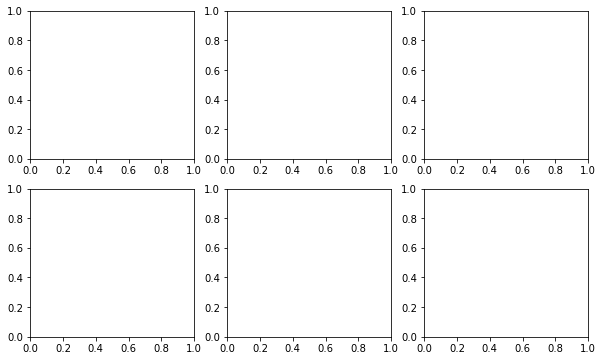

In [3]:
#Model Daten
ant_model = '.././model/OIE_model.ant'


#experimentelle Daten
data_df = pd.read_excel('.././datasets/haemolysismodel_conRetis.xlsx')  
df = dsl.long_format(data_df)
df_experimental_data = pf.preprocess_experimental_df(df, '59', pf.get_lab_values())
#Optimization 


with open ('20230814-12-52-29paras_optimized.json', 'r') as jsonfile:    #r= only read
    optimize_results_file = json.load(jsonfile, object_pairs_hook=OrderedDict)


for index in range(len(optimize_results_file["results"])):
    new_dict = optimize_results_file["results"][index]["best_params"]
    df_simulated_data = pf.simulate_model(ant_model , pf.get_lab_values(),new_dict )

    #Plotten
    print(f'score:{optimize_results_file["results"][index]["best_score"]}')
    pf.plot_simulation_and_experiment(df_experimental_data, df_simulated_data)

#df_simulated_data

Index(['time', 'Hkt', '[E]', 'Hb', 'LDH', '[R]', '[oiE]'], dtype='object')
score:5.00006847961229
Index(['time', 'Hkt', '[E]', 'Hb', 'LDH', '[R]', '[oiE]'], dtype='object')
score:5.000068521291049
Index(['time', 'Hkt', '[E]', 'Hb', 'LDH', '[R]', '[oiE]'], dtype='object')
score:5.000069948897737
Index(['time', 'Hkt', '[E]', 'Hb', 'LDH', '[R]', '[oiE]'], dtype='object')
score:5.000068412860132
Index(['time', 'Hkt', '[E]', 'Hb', 'LDH', '[R]', '[oiE]'], dtype='object')
score:5.000068420777106
Index(['time', 'Hkt', '[E]', 'Hb', 'LDH', '[R]', '[oiE]'], dtype='object')
score:5.0000687457053035
Index(['time', 'Hkt', '[E]', 'Hb', 'LDH', '[R]', '[oiE]'], dtype='object')
score:5.000068505736677
Index(['time', 'Hkt', '[E]', 'Hb', 'LDH', '[R]', '[oiE]'], dtype='object')
score:5.000068421478359
Index(['time', 'Hkt', '[E]', 'Hb', 'LDH', '[R]', '[oiE]'], dtype='object')
score:5.000068756260411
Index(['time', 'Hkt', '[E]', 'Hb', 'LDH', '[R]', '[oiE]'], dtype='object')
score:5.000068745705123


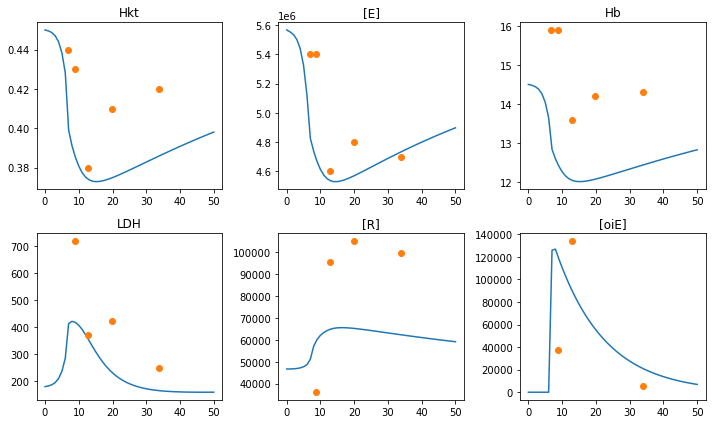

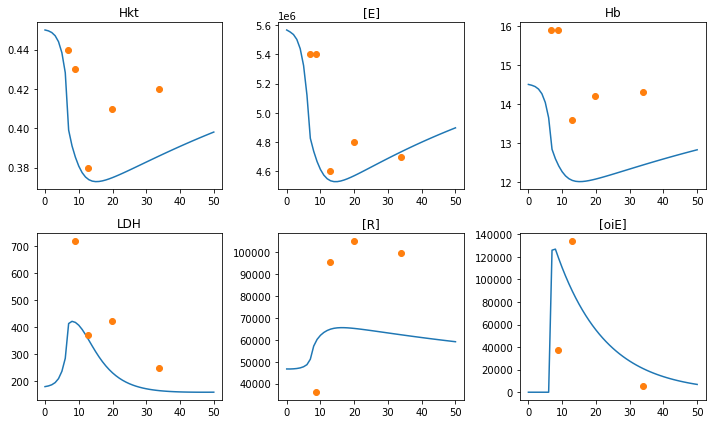

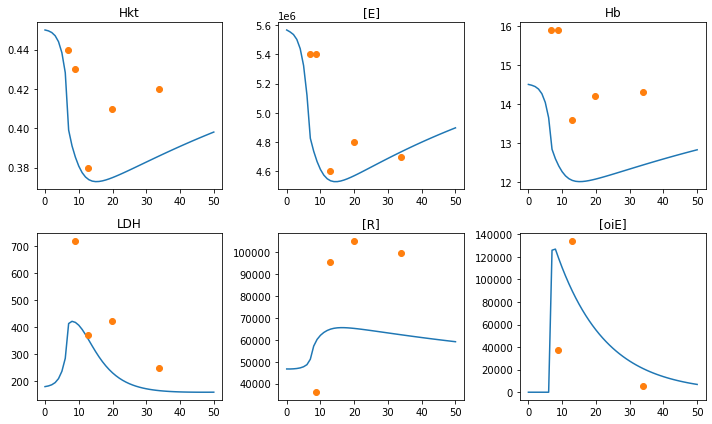

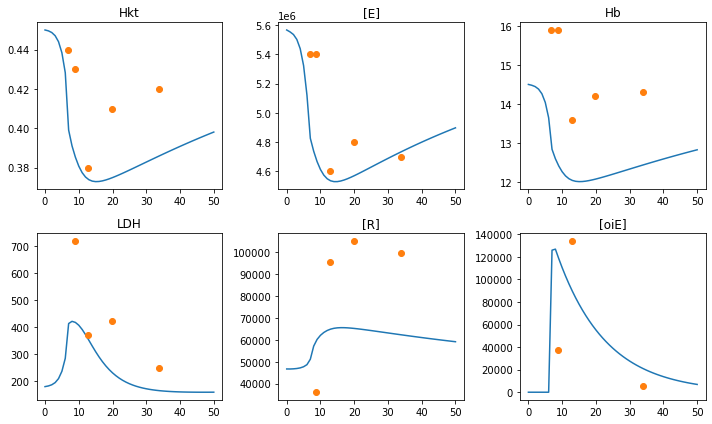

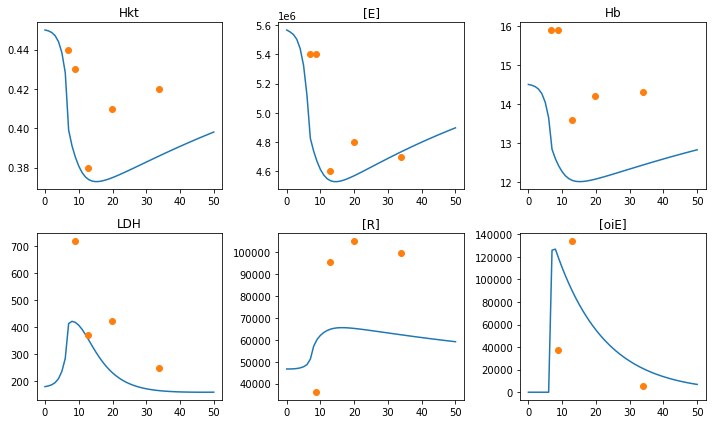

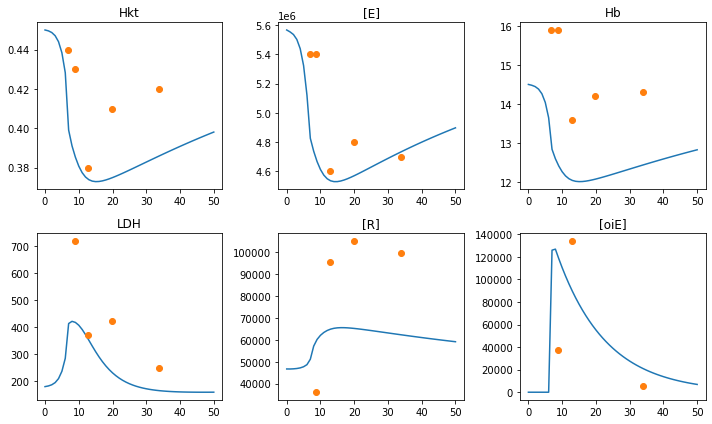

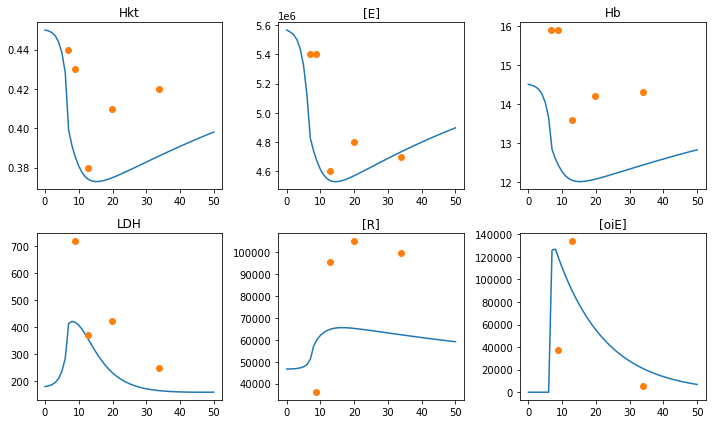

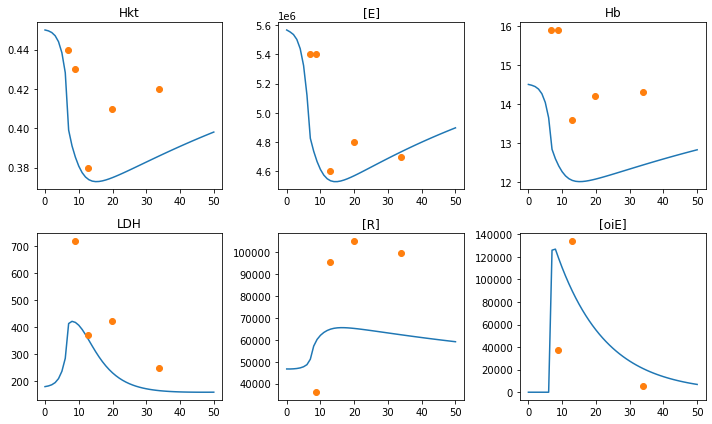

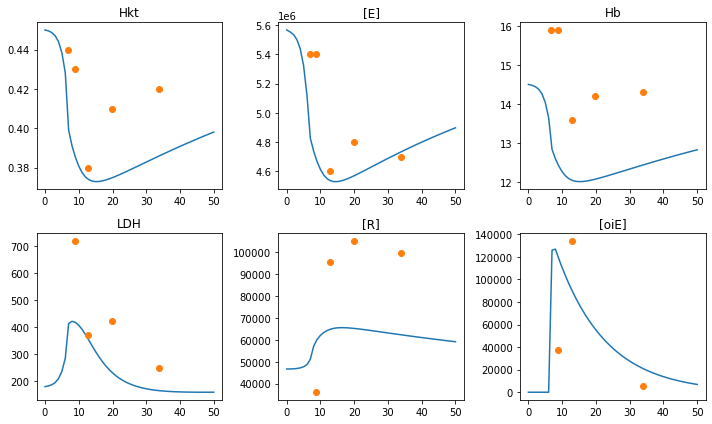

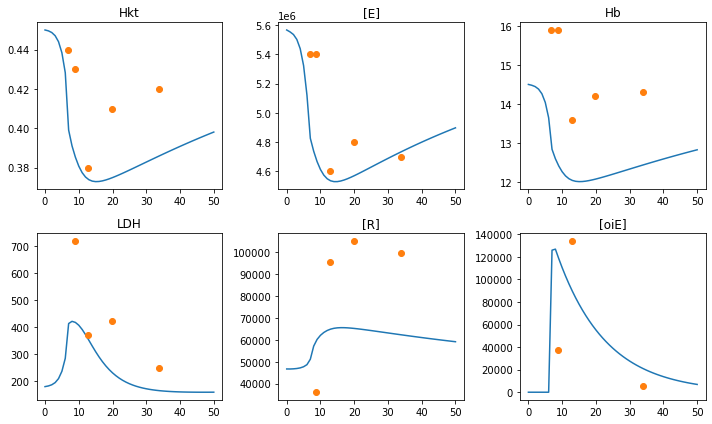

In [5]:
# Plotting full timeline included only infection

#Model Daten
ant_model = '.././model/OIE_model.ant'
ant_model = te.loada(ant_model)
patient = '36'

#experimentelle Daten
data_df = pd.read_excel('.././datasets/haemolysismodel_conRetis.xlsx')   
df = dsl.long_format(data_df)
df_experimental_data = pf.preprocess_experimental_df(df, patient, pf.get_lab_values())
#Optimization 


with open ('20230814-12-52-29paras_optimized.json', 'r') as jsonfile:   #r= only read
#with open ('20230707-17-53-05paras_optimized.json', 'r') as jsonfile:    #r= only read
    optimize_results_file = json.load(jsonfile, object_pairs_hook=OrderedDict)


for index in range(len(optimize_results_file["results"])):
    new_dict = optimize_results_file["results"][index]["best_params"]
    ant_model = pf.update_model(ant_model, new_dict)
    res = ant_model.simulate(0, 50, selections=['time']+pf.get_lab_values())
    df_simulated_data = pd.DataFrame(res, columns=res.colnames)
    print(df_simulated_data.columns)
    #df_simulated_data.set_index('time', inplace=True)
    #df_simulated_data = pf.simulate_model(ant_model , pf.get_lab_values(),new_dict )

    #Plotten
    print(f'score:{optimize_results_file["results"][index]["best_score"]}')
    df_experimental_data['time'] = df_experimental_data.index + 10**new_dict['t_ART_add']
    fig = pf.plot_simulation_and_experiment(df_experimental_data, df_simulated_data)

#df_simulated_data
# for axi in fig.axes:
#     axi.set_xlim(5, 10)

plt.show()

Index(['time', 'Hkt', '[E]', 'Hb', 'LDH', '[R]', '[oiE]'], dtype='object')
score:1608.0064267497125
Index(['time', 'Hkt', '[E]', 'Hb', 'LDH', '[R]', '[oiE]'], dtype='object')
score:1608.0064396893692


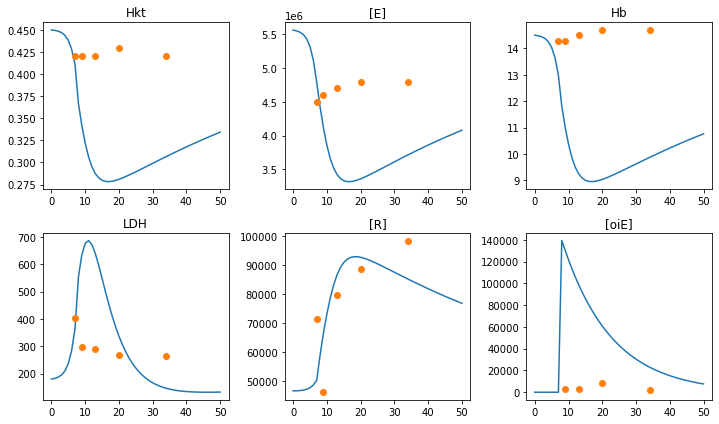

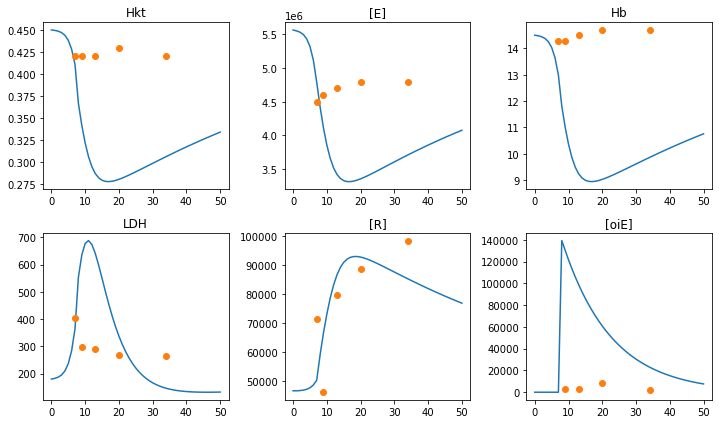

In [8]:
# Plotting full timeline included only infection

#Model Daten
ant_model = '.././model/OIE_model.ant'
ant_model = te.loada(ant_model)
patient = '59'

#experimentelle Daten
data_df = pd.read_excel('.././datasets/haemolysismodel_conRetis.xlsx')   
df = dsl.long_format(data_df)
df_experimental_data = pf.preprocess_experimental_df(df, patient, pf.get_lab_values())
#Optimization 

#30815-11-08-00paras_optimized.json
#with open ('20230814-12-54-32paras_optimized.json
with open ('20230815-11-08-00paras_optimized.json', 'r') as jsonfile:   #r= only read
#with open ('20230707-17-53-05paras_optimized.json', 'r') as jsonfile:    #r= only read
    optimize_results_file = json.load(jsonfile, object_pairs_hook=OrderedDict)


for index in range(len(optimize_results_file["results"])):
    new_dict = optimize_results_file["results"][index]["best_params"]
    ant_model = pf.update_model(ant_model, new_dict)
    res = ant_model.simulate(0, 50, selections=['time']+pf.get_lab_values())
    df_simulated_data = pd.DataFrame(res, columns=res.colnames)
    print(df_simulated_data.columns)
    #df_simulated_data.set_index('time', inplace=True)
    #df_simulated_data = pf.simulate_model(ant_model , pf.get_lab_values(),new_dict )

    #Plotten
    print(f'score:{optimize_results_file["results"][index]["best_score"]}')
    df_experimental_data['time'] = df_experimental_data.index + 10**new_dict['t_ART_add']
    #df_experimental_data['time'] = df_experimental_data.index + 7       # nur wenn t_ART add nicht gefittet
    fig = pf.plot_simulation_and_experiment(df_experimental_data, df_simulated_data)

#df_simulated_data
# for axi in fig.axes:
#     axi.set_xlim(5, 10)

plt.show()

In [9]:
df_experimental_data

df_experimental_data['[iE]'].mean()

10800.0

Index(['time', 'Hkt', '[E]', 'Hb', 'LDH', '[R]', '[oiE]', 'k_E_death', '[iE]',
       '[P]', 'J_P_death', '[R]', 'RPI'],
      dtype='object')
score:1608.0064267497125
Index(['time', 'Hkt', '[E]', 'Hb', 'LDH', '[R]', '[oiE]', 'k_E_death', '[iE]',
       '[P]', 'J_P_death', '[R]', 'RPI'],
      dtype='object')
score:1608.0064396893692


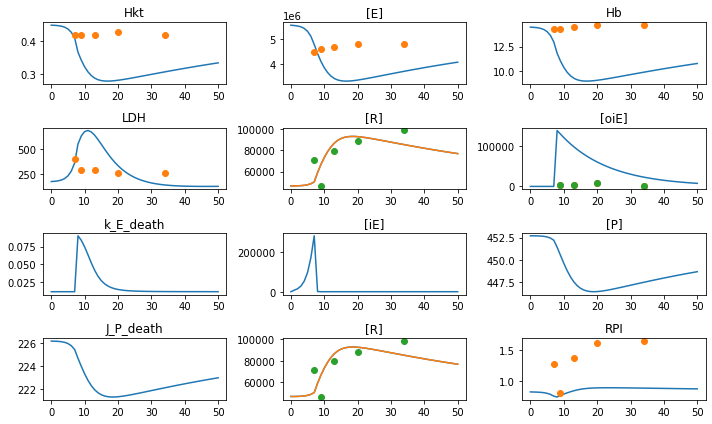

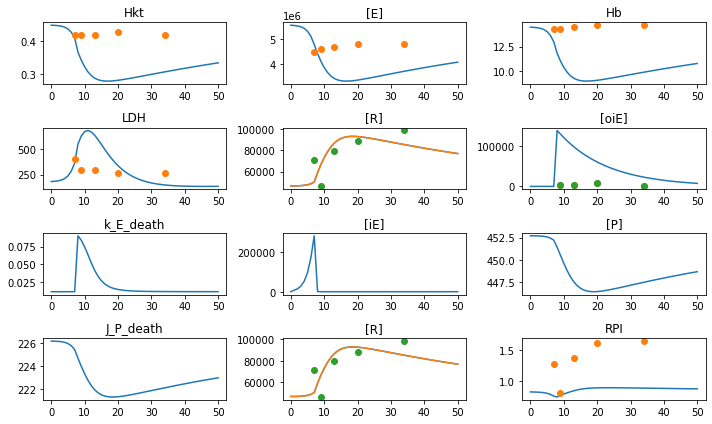

In [9]:


lab_values = pf.get_lab_values()
additional_values = ['k_E_death', '[iE]', '[P]', 'J_P_death', '[R]', 'RPI']
all_values = lab_values + additional_values
experimental_values = ['[oiE]', 'RPI']



#with open ('20230815-11-08-00paras_optimized.json', 'r') as jsonfile:   #r= only read
with open ('20230712-16-08-09paras_optimized.json', 'r') as jsonfile:    #r= only read
    optimize_results_file = json.load(jsonfile, object_pairs_hook=OrderedDict)

#Model Daten
ant_model = '.././model/OIE_model.ant'
ant_model = te.loada(ant_model)
patient = optimize_results_file["metadata"]["patient"]

#experimentelle Daten
data_df = pd.read_excel('.././datasets/haemolysismodel_conRetis.xlsx')   
df = dsl.long_format(data_df)
df_experimental_data = pf.preprocess_experimental_df(df, patient, lab_values+experimental_values)
#Optimization 


for index in range(len(optimize_results_file["results"])):
    new_dict = optimize_results_file["results"][index]["best_params"]
    ant_model = pf.update_model(ant_model, new_dict)
    res = ant_model.simulate(0, 50, selections=['time']+ all_values)
    df_simulated_data = pd.DataFrame(res, columns=res.colnames)
    print(df_simulated_data.columns)
    #df_simulated_data.set_index('time', inplace=True)
    #df_simulated_data = pf.simulate_model(ant_model , pf.get_lab_values(),new_dict )

    #Plotten
    print(f'score:{optimize_results_file["results"][index]["best_score"]}')
    df_experimental_data['time'] = df_experimental_data.index + 10**new_dict['t_ART_add']
    #df_experimental_data['time'] = df_experimental_data.index + 7

    n_subplots = len(all_values)
    n_cols = 3
    n_rows = int(np.ceil(n_subplots/n_cols))
    



    fig, ax = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(10,6))

    for i, lab_value in enumerate(all_values):
        col = i%n_cols
        row = i//n_cols
        ax[row, col].plot(df_simulated_data.time, df_simulated_data[lab_value])
        if lab_value in df_experimental_data.columns:   
            ax[row, col].plot(df_experimental_data.time, df_experimental_data[lab_value],'o')
        ax[row, col].set_title(lab_value)
    


    plt.tight_layout()
    



#df_simulated_data
# for axi in fig.axes:
#     axi.set_xlim(5, 10)

plt.show()

Index(['time', 'Hb', 'k_E_death', '[iE]', '[P]', 'J_P_death', '[E]'], dtype='object')
score:0.019922621912783687


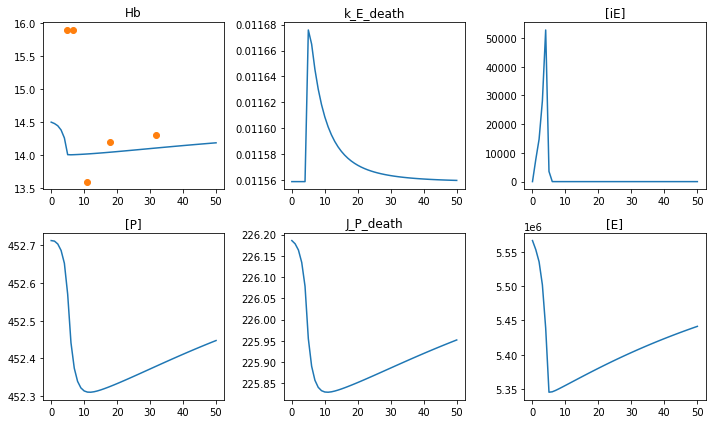

In [4]:


lab_values = pf.get_lab_values()
additional_values = ['k_E_death', '[iE]', '[P]', 'J_P_death', '[E]']
all_values = lab_values + additional_values

with open ('20230712-16-08-09paras_optimized.json', 'r') as jsonfile:    #r= only read
    optimize_results_file = json.load(jsonfile, object_pairs_hook=OrderedDict)

#Model Daten
ant_model = '.././model/OIE_model.ant'
ant_model = te.loada(ant_model)
patient = optimize_results_file["metadata"]["patient"]

#experimentelle Daten
data_df = pd.read_excel('.././datasets/haemolysismodel_conRetis.xlsx')   
df = dsl.long_format(data_df)
df_experimental_data = pf.preprocess_experimental_df(df, patient, pf.get_lab_values())
#Optimization 


for index in range(len(optimize_results_file["results"])):
    new_dict = optimize_results_file["results"][index]["best_params"]
    ant_model = pf.update_model(ant_model, new_dict)
    res = ant_model.simulate(0, 50, selections=['time']+ all_values)
    df_simulated_data = pd.DataFrame(res, columns=res.colnames)
    print(df_simulated_data.columns)
    #df_simulated_data.set_index('time', inplace=True)
    #df_simulated_data = pf.simulate_model(ant_model , pf.get_lab_values(),new_dict )

    #Plotten
    print(f'score:{optimize_results_file["results"][index]["best_score"]}')
    df_experimental_data['time'] = df_experimental_data.index + 10**new_dict['t_ART_add']

    n_subplots = len(all_values)
    n_cols = 3
    n_rows = int(np.ceil(n_subplots/n_cols))
    



    fig, ax = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(10,6))

    for i, lab_value in enumerate(all_values):
        col = i%n_cols
        row = i//n_cols
        ax[row, col].plot(df_simulated_data.time, df_simulated_data[lab_value])
        if lab_value in df_experimental_data.columns:   
            ax[row, col].plot(df_experimental_data.time, df_experimental_data[lab_value],'o')
        ax[row, col].set_title(lab_value)
    


    plt.tight_layout()
    



#df_simulated_data
# for axi in fig.axes:all_values
#     axi.set_xlim(5, 10)

plt.show()

## Results Analysis

In [2]:
# Extract fitting paraemter value and covariance matrix from Fitting
fitted_params = best_paramvalues        #Optimal parameter values
cov_matrix    = best_covmatrix          #Convariance matrix = inverse hesse matrix, todense() makes matrix to dense array, but i dont unterstand why without it only shows adress?? 
objectiv_score= best_objectiv_score

# Calculate Parameter Sensivity
param_std = np.sqrt(np.diag(cov_matrix))  # get diagonal elements from hessian matrix (=variances), then calculate the square roots of variances (=standart deviation -> = sensivity)

# Calculate Parameter Confidence Intervals (95% level)
alpha = 0.05      #significance level, probability of rejecting the null hypothesis when it is actually true
gamma = 1- alpha  #= 0.95 confidence level, probability that the true population parameter lies within the confidence interval
z_value = norm.ppf(1- alpha/2)  # z-value from table for given alpha, divide by 2 because want the z value for only one sider of normal distribution  #1.96

#n = len(df_experimental_data) #??????????????????????????????? FALSCh, muss korrigiert werden, 
#CI = np.array(z_value * param_std / np.sqrt(n))


# Calculate p-value for the goodness of fit
num_experim_points = 40-10   #how to get number of datapoints from dataframe experiments?
deg_freedom = num_experim_points - len(fitted_params)  # Degrees of freedom = N-P
p_value = 1 - chi2.cdf(objectiv_score, deg_freedom)

# Print the results
print("Parameter names:", params_guess.keys())
print("Fitted parameter values:", fitted_params)
print("Parameter sensitivities:", param_std)
#print("Parameter confidence intervals (95% level):", CI)
print("Chi-square value:", objectiv_score)
print("Degrees of freedom:", deg_freedom)
print("p-value for goodness of fit:", p_value)

params.keys()




NameError: name 'best_paramvalues' is not defined

In [ ]:
# Latin Hypercube Sampling (LHS)

# define number of samples to generate
n_samples = 100   

# define sample dimension, i.e. number of parameters
params_log_bounds = pf.convert_bounds_to_logscale(params_bounds)                                           
sample_dim = len(params_log_bounds)   

# Create the sampler object
sampler = qmc.LatinHypercube(d=sample_dim)  

# Generate LHS samples
lhs_log_sample = sampler.random(n=n_samples)

# Scale the samples using the parameter bounds in log10 scale
lower_bounds = [params_log_bounds[param][0] for param in params_log_bounds]
upper_bounds = [params_log_bounds[param][1] for param in params_log_bounds]
lhs_log_sample = qmc.scale(lhs_log_sample, lower_bounds, upper_bounds)

# Convert the samples back to the original space
params_values = OrderedDict({})(as shown in the appendix figure for an extended timeframe).
for i, (param, bounds) in enumerate(params_log_bounds.items()):
    params_values[param] = 10 ** np.interp(lhs_log_sample[:, i], (0, 1), bounds)

# Print the parameter values for the first 5 samples
for i in range(10):
    print(f'Sample {i}: {params_values["param2_EPOprod"][i]}, {params_values["param3_EPOprod"][i]}')




Sample 0: 300.0000000000001, 0.0004999999999999999
Sample 1: 300.0000000000001, 0.0004999999999999999
Sample 2: 0.4957409175571717, 0.0004999999999999999
Sample 3: 161.1952484257631, 0.0004999999999999999
Sample 4: 0.29999999999999993, 0.0004999999999999999
Sample 5: 300.0000000000001, 0.0004999999999999999
Sample 6: 0.29999999999999993, 0.0004999999999999999
Sample 7: 300.0000000000001, 0.0004999999999999999
Sample 8: 300.0000000000001, 0.0004999999999999999
Sample 9: 58.91088418356803, 0.0004999999999999999
